## **Preparando o ambiente - Instalações e Configurações**

### Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import requests
from copy import deepcopy
import datetime

import math
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)


# Importa as bibliotecas do banco central ##adjust
!pip install -q -U python-bcb
import seaborn as sns
from bcb import sgs

# Lib trading view ##adjust
!pip install -q -U --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
from tvDatafeed import TvDatafeed, Interval

# #Acesso ao Drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


### Parâmetros Ativo e Window_Size

In [ ]:
ativo = 'SANB11.SA' # Ativos eletivos: 'BBAS3.SA', 'BBDC4.SA', 'BPAC11.SA', 'ITUB4.SA', 'SANB11.SA'
window_size = 5

## **Preparando o ambiente - Funções utilitárias**

In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [ ]:
# [[[c1, h1, ise1, ifnc1, camels1, cambio1], [c2...], [c3...], [c4...], [c5...]]] [c6]
# [[[c2], [c3], [c4], [c5], [c6]]] [c7]
# [[[c3], [c4], [c5], [c6], [c7]]] [c8]

def cria_janela_modelo(df, window_size):
  df_as_np = df.to_numpy()
  X = [] #numero de exemplos de treino e numero de variaveis
  y = []
  for i in range(len(df_as_np)-window_size):
    #listas de variaveis que será coletada do dataframe na coluna selecionada
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)

    #seleciona a primeira variavel do dataframe como label, que é a que será prevista em t+1. mudar referencia para 'Close' ##adjust
    label = df_as_np[i+window_size][0]
    y.append(label)

  #saída da função será as variáveis de input(X) e output(y)
  #shape das variaveis de saida:
  #X = (numero de exemplos entrada de treino, tamanho da janela, numero de variaveis aux)
  #y = (numero de exemplos de saída de treino, )
  return np.array(X), np.array(y)

In [ ]:
def reorganiza_colunas(df):
  if 'Close' in df.columns:
      nova_ordem_colunas = ['Close'] + [coluna for coluna in df.columns if coluna != 'Close']
      df = df[nova_ordem_colunas]
  return df

## **Buscando dados - Ativo**


In [ ]:
start_date, end_date = '2020-01-01', '2023-07-31'
data = yf.download(ativo, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


## **Buscando dados - Indicadores (ISE, IFNC e BVSP)**

In [ ]:
username = 'oantenor'; password = 'antrading1q2w3e4r'
tv = TvDatafeed(username, password)

#ise
isedata = tv.get_hist(symbol='ISEE',
                 exchange='BMFBOVESPA',interval=Interval.in_daily,n_bars=10000)
isedata.index = pd.to_datetime(isedata.index).date
ISE = pd.DataFrame(); ISE['ISE'] = isedata['close']

#ifnc
ifncdata = tv.get_hist(
                       symbol='IFNC',
                       exchange='BMFBOVESPA',
                       interval=Interval.in_daily,n_bars=10000)
ifncdata.index = pd.to_datetime(ifncdata.index).date
IFNC = pd.DataFrame(); IFNC['IFNC'] = ifncdata['close']

ERROR:tvDatafeed.main:error while signin


In [ ]:
bvsp = yf.download('^BVSP', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


## **Buscando dados - Taxa de Juros, Cambio**

In [ ]:
selic = sgs.get({'selic':432}, start = start_date)

In [ ]:
taxa_cambio = yf.download('BRLUSD=X', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


## **Carregando variáveis CAMELS**

In [ ]:
camels = pd.read_csv(f'/content/drive/MyDrive/ARTIGO_LSTM/camels_bancos/{ativo}_full.csv')
# camels = pd.read_csv('df_itau_full.csv')
camels['Data'] = camels['Data'].apply(str_to_datetime)
camels = camels.rename(columns={'Data': 'Date'})

## **Definindo dataframe que será utilizado**

In [ ]:
micro_macro_df = data
micro_macro_df['ise'] = isedata['close']
micro_macro_df['ifnc'] = ifncdata['close']
micro_macro_df['selic'] = selic['selic']
micro_macro_df['taxa_cambio'] = taxa_cambio['Close']
micro_macro_df['bvsp'] = bvsp['Close']

In [ ]:
input_lstm_data = micro_macro_df.dropna()

In [ ]:
input_lstm_data = pd.merge(micro_macro_df, camels, on='Date', how='inner')

In [ ]:
input_lstm_data = input_lstm_data.dropna()
input_lstm_data.index = input_lstm_data.pop('Date')
input_lstm_data = reorganiza_colunas(input_lstm_data)
input_lstm_data.head(7)

,Close,Open,High,Low,Adj Close,Volume,ise,ifnc,selic,taxa_cambio,...,e_roe,e_oroa,e_oroe,i_deposscapt,i_liquidsta,i_liquidscapt,i_deposta,i_depexig,s_expmoes,s_expJur
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,51.040001,50.000000,51.549999,49.820000,38.901329,1752000,4203.7002,13612.13,4.5,0.248985,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-03,51.009998,50.520000,51.330002,50.509998,38.878445,1346800,4210.3701,13505.56,4.5,0.248546,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-06,47.509998,48.310001,48.660000,47.349998,37.759090,1303400,4173.0200,13374.46,4.5,0.246488,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-07,47.410000,47.599998,47.980000,47.060001,37.679615,1086400,4170.8198,13299.94,4.5,0.246281,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-08,47.040001,47.560001,47.740002,46.599998,37.385548,629300,4167.1001,13160.53,4.5,0.245930,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-09,46.150002,46.880001,47.360001,46.009998,36.678215,987700,4154.4902,13036.25,4.5,0.246136,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219
2020-01-10,45.950001,46.400002,46.770000,45.910000,36.519268,776000,4166.4102,12901.07,4.5,0.244373,...,0.02008,0.001394,0.020012,0.335091,0.421128,0.453331,0.311287,0.335106,0.175022,0.011219


##**Definindo a janela de previsão**


In [ ]:
input_lstm_data.shape

(888, 37)

In [ ]:
#dataframe de dados, tamanho da janela
input_lstm, output_lstm = cria_janela_modelo(input_lstm_data, window_size)

In [ ]:
#tamanho da amostra, tamanho da janela, numero de variaveis de interesse
input_lstm.shape, output_lstm.shape

((883, 5, 37), (883,))

##**Definição das amostras de treino e teste**


In [ ]:
train_data_length = math.ceil(len(input_lstm)*0.8)
input_train, output_train = input_lstm[:train_data_length], output_lstm[:train_data_length]
print("Shape dados de treino: ", input_train.shape, output_train.shape)
input_test, output_test = input_lstm[train_data_length:], output_lstm[train_data_length:]
print("Shape dados de teste: ", input_test.shape, output_test.shape)

Shape dados de treino:  (707, 5, 37) (707,)
Shape dados de teste:  (176, 5, 37) (176,)


In [ ]:
outputs = input_lstm_data['Close'][(train_data_length+window_size):]
outputs = outputs.reset_index()
rw = input_lstm_data['Close'].shift(1)
rw = rw[(train_data_length+window_size):].reset_index()
outputs['RW']=rw['Close']; outputs.shape

(176, 3)

### Conferência (opcional)

In [ ]:
#Conferência manual das Métricas de erro para o modelo Random Walk, RW
d = outputs['Close']-outputs['RW']
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
mape_f = np.mean(100*abs(d)/outputs['Close'])
rmse_f = np.sqrt(mse_f)
print(f'MAE: {mae_f}','\n',f'RMSE: {rmse_f}','\n',f'MAPE: {mape_f}')

MAE: 0.3575568307529796 
 RMSE: 0.45773969809462245 
 MAPE: 1.2573708610757328


In [ ]:
#Conferência das Métricas de erro para RW via sklearn.metrics. Obs: os valores devem ser os mesmos do output anterior.
mae_rw = mean_absolute_error(outputs['Close'], outputs['RW'])
rmse_rw = mean_squared_error(outputs['Close'], outputs['RW']) ** 0.5
mape_rw = 100*mean_absolute_percentage_error(outputs['Close'], outputs['RW'])
print(f'MAE: {mae_rw}','\n',f'RMSE: {rmse_rw}','\n',f'MAPE: {mape_rw}')

MAE: 0.3575568307529796 
 RMSE: 0.45773969809462245 
 MAPE: 1.2573708610757328


##**Normalização**

In [ ]:
scaler = StandardScaler(); scaler2 = StandardScaler()
input_train = scaler.fit_transform(input_train.reshape(-1, input_train.shape[-1])).reshape(input_train.shape)
input_test = scaler.transform(input_test.reshape(-1, input_test.shape[-1])).reshape(input_test.shape)
output_train = scaler2.fit_transform(output_train.reshape(-1, 1))
output_test = scaler2.transform(output_test.reshape(-1, 1))

## **Treinando modelo LSTM**

In [ ]:
random.seed(seed=1234)
model = Sequential()
model.add(InputLayer((window_size, 37)))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               84992     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 85121 (332.50 KB)
Trainable params: 85121 (332.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# cp4 = ModelCheckpoint('model4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
history = model.fit(input_train, output_train, batch_size=64, epochs=100, validation_data=(input_test, output_test))

Epoch 1/100
12/12 [==============================] - 3s 67ms/step - loss: 0.4370 - root_mean_squared_error: 0.6611 - val_loss: 0.3247 - val_root_mean_squared_error: 0.5698
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.5890 - val_root_mean_squared_error: 0.7675
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0775 - root_mean_squared_error: 0.2783 - val_loss: 0.1605 - val_root_mean_squared_error: 0.4006
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.1330 - val_root_mean_squared_error: 0.3648
Epoch 5/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.1959 - val_root_mean_squared_error: 0.4426
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.1872 - val_

## **Pós processamento - Desfazendo a normalização**

## **Definindo predições com dados de teste e treino**

In [ ]:
output_train_reverse = scaler2.inverse_transform(output_train.reshape(-1, 1))
output_test_reverse = scaler2.inverse_transform(output_test.reshape(-1, 1))

In [ ]:
train_predictions = model.predict(input_train)
test_predictions = model.predict(input_test)

6/6 [==============================] - 0s 4ms/step


In [ ]:
train_predictions.shape

(707, 1)

In [ ]:
pred_train = scaler2.inverse_transform(train_predictions)
pred_test = scaler2.inverse_transform(test_predictions)

## **Cálculo das métricas do modelo LSTM**

In [ ]:
mae_train = mean_absolute_error(output_train_reverse, pred_train)
rmse_train = mean_squared_error(output_train_reverse, pred_train) ** 0.5
mape_train = 100*mean_absolute_percentage_error(output_train_reverse, pred_train)

mae_test = mean_absolute_error(output_test_reverse, pred_test)
rmse_test = mean_squared_error(output_test_reverse, pred_test) ** 0.5
mape_test = 100*mean_absolute_percentage_error(output_test_reverse, pred_test)

data = [['MAE', mae_test],
        ['MAPE', mape_test],
        ['RMSE', rmse_test]]

df_lstm_metrics = pd.DataFrame(data, columns=['Métrica', 'LSTM Teste'])

In [ ]:
df_lstm_metrics

,Métrica,LSTM Teste
0,MAE,2.636894
1,MAPE,9.431933
2,RMSE,2.771302


In [ ]:
mae_test1 = mean_absolute_error(outputs['Close'], pred_test)
rmse_test1 = mean_squared_error(outputs['Close'], pred_test) ** 0.5
mape_test1 = 100*mean_absolute_percentage_error(outputs['Close'], pred_test)

data1 = [['MAE', mae_test1],
        ['MAPE', mape_test1],
        ['RMSE', rmse_test1]]

df_lstm_metrics1 = pd.DataFrame(data1, columns=['Métrica', 'LSTM Teste']); df_lstm_metrics1

,Métrica,LSTM Teste
0,MAE,2.636894
1,MAPE,9.431933
2,RMSE,2.771302


## **Cálculo das métricas Random Walk**

In [ ]:
mae_rw = mean_absolute_error(outputs['Close'], outputs['RW'])
rmse_rw = mean_squared_error(outputs['Close'], outputs['RW']) ** 0.5
mape_rw = 100*mean_absolute_percentage_error(outputs['Close'], outputs['RW'])

data = [['MAE', mae_rw],
        ['MAPE', mape_rw],
        ['RMSE', rmse_rw]]

df_rw_metrics = pd.DataFrame(data, columns=['Métrica', 'RW'])

In [ ]:
df_rw_metrics

,Métrica,RW
0,MAE,0.357557
1,MAPE,1.257371
2,RMSE,0.457740


In [ ]:
df_metrics = pd.merge(df_lstm_metrics, df_rw_metrics, on='Métrica', how='inner')

In [ ]:
df_metrics

,Métrica,LSTM Teste,RW
0,MAE,2.636894,0.357557
1,MAPE,9.431933,1.257371
2,RMSE,2.771302,0.457740


In [ ]:
import os
path = f'/content/drive/MyDrive/ARTIGO_LSTM/outputs/{ativo}/'
if not os.path.exists(path):
   os.makedirs(path)
df_metrics.to_csv(f'/content/drive/MyDrive/ARTIGO_LSTM/outputs/{ativo}/metrics_{window_size}_dias.csv', index=False)

In [ ]:
outputs['LSTM'] = pd.DataFrame(pred_test)
outputs['Erro.RW'] = outputs['RW'] - outputs['Close']
outputs['Erro.LSTM'] = outputs['LSTM'] - outputs['Close']#; outputs

In [ ]:
outputs.to_csv(path+f'outputs_{ativo}_{window_size}_dias.csv', sep=',', index=False)

### Figuras

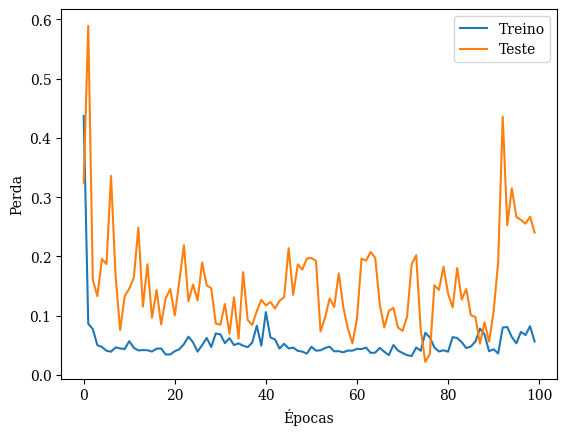

In [ ]:
## Loss Curve
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Teste')
#plt.title('Training and Validation Loss Curves')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.savefig(path+f'fig1_loss_{ativo}_{window_size}_dias.png', dpi=300)
#plt.show()

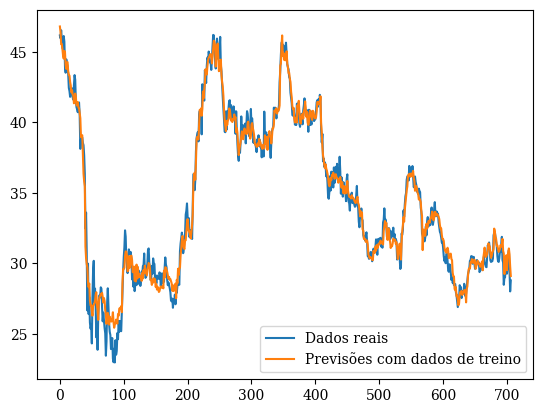

In [ ]:
#Dados de Treino
plt.plot(output_train_reverse, label='Dados reais')
plt.plot(pred_train, label='Previsões com dados de treino')
plt.legend()
plt.savefig(path+f'fig2_treino_{ativo}_{window_size}_dias.png', dpi=300)


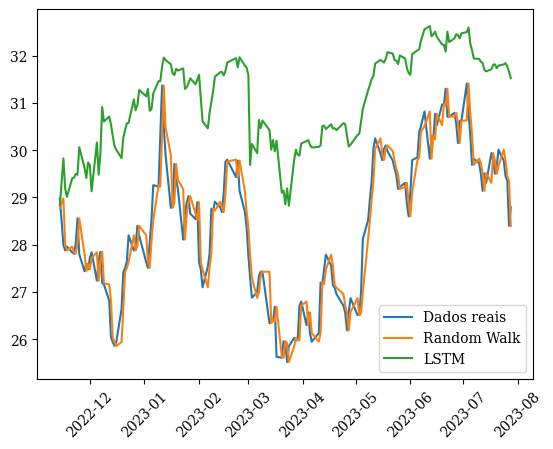

In [ ]:
#Dados de Teste
plt.plot(outputs['Date'], outputs['Close'], label='Dados reais')
plt.plot(outputs['Date'], outputs['RW'], label='Random Walk')
plt.plot(outputs['Date'], outputs['LSTM'], label='LSTM')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.legend()
plt.savefig(path+f'fig3_teste_{ativo}_{window_size}_dias.png', dpi=300)


## Testes de Significância

### Diferenças nas previsões

In [ ]:
!pip install -q -U dieboldmariano

In [ ]:
from dieboldmariano import dm_test

In [ ]:
#Teste de Diebold-Mariano para MAPE
DM_mape = dm_test(outputs['Close'],outputs['RW'],outputs['LSTM'], loss = lambda x, y: abs((x - y)/y), one_sided=False)

#Teste de Diebold-Mariano para MAE
DM_mae = dm_test(outputs['Close'],outputs['RW'],outputs['LSTM'], loss = lambda x, y: abs(x - y), one_sided=False)

#Teste de Diebold-Mariano para MSE >> adotar para RMSE
DM_mse = dm_test(outputs['Close'],outputs['RW'],outputs['LSTM'], one_sided=False)

In [ ]:
# Resultado do Teste
##MAPE
estat_mape = DM_mape[0];  p_mape = DM_mape[1]

# Tomar decisão com base no valor p
alpha = 0.05  # Nível de significância
a = "Rejeitar a hipótese nula - há evidências de diferença significativa entre as médias."
b = "Falha em rejeitar a hipótese nula - não há evidências suficientes de diferença significativa entre as médias."

if p_mape < alpha:
    result_mape = a
else:
    result_mape = b
#print(result_mape)

##MAE
estat_mae = DM_mae[0];  p_mae = DM_mae[1]

# Tomar decisão com base no valor p
alpha = 0.05  # Nível de significância
a = "Rejeitar a hipótese nula - há evidências de diferença significativa entre as médias."
b = "Falha em rejeitar a hipótese nula - não há evidências suficientes de diferença significativa entre as médias."

if p_mape < alpha:
    result_mae = a
else:
    result_mae = b
#print(result_mae)

##MSE
estat_mse = DM_mse[0];  p_mse = DM_mse[1]

# Tomar decisão com base no valor p
alpha = 0.05  # Nível de significância
a = "Rejeitar a hipótese nula - há evidências de diferença significativa entre as médias."
b = "Falha em rejeitar a hipótese nula - não há evidências suficientes de diferença significativa entre as médias."

if p_mse < alpha:
    result_mse = a
else:
    result_mse = b
#print(result_mae)

In [ ]:
lines = ['Diebold-Mariano Test', '\n', f'Ativo analisado: {ativo}', '\n',
         f'Estatística do Teste para MAPE: {estat_mape}', f'p-valor: {p_mape}',
         f'Resultado: {result_mape}','\n',
         f'Estatística do Teste para MAE: {estat_mae}', f'p-valor: {p_mae}',
         f'Resultado: {result_mae}','\n',
         f'Estatística do Teste para RMSE: {estat_mse}', f'p-valor: {p_mse}',
         f'Resultado: {result_mse}','\n',]
with open(path + f'teste-resultados_{ativo}_{window_size}.txt', 'w') as f:
    f.write('\n'.join(lines))